In [1]:
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.insert(0,'/content/drive/MyDrive/CS247/Models')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
from util import *
from model import MLPEmbedding
from model import GMF
from evaluate import *
import torch
import torch.nn as nn
from torch import optim

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
train_data = pd.read_pickle("/content/drive/MyDrive/CS247/Data/train_data.pkl")
val_data = pd.read_pickle("/content/drive/MyDrive/CS247/Data/val_data.pkl")
test_data = pd.read_pickle("/content/drive/MyDrive/CS247/Data/test_data.pkl")[['review_profilename','beer_name','review_overall']]
test_data = merge_user_id(test_data, on='review_profilename').rename(columns={'id':'user_id'})
test_data = merge_beer_id(test_data, on='beer_name').rename(columns={'id':'beer_id'})[['user_id','beer_id','review_overall']]

In [4]:
# convert review score to boolean - if the item is relevant to the user (rating >= 3.5) then 1, else 0
threshold = 4.0
train_data['relevant'] = (train_data['review_overall'] >= threshold).astype(int)
train_data.head()

,user_id,beer_id,review_overall,relevant
383941,415,831,3.5,0
483700,2492,3491,4.0,1
375376,1233,1178,4.5,1
705138,1230,902,4.5,1
435972,2290,7497,3.5,0


In [5]:
### unique users & beers in train_data
n_users = len(train_data['user_id'].unique())
n_beers = len(train_data['beer_id'].unique())
print("unique users: ", n_users)
print("unique beers: ", n_beers)

unique users:  14811
unique beers:  52583


In [6]:
class NeuMF(nn.Module):
  def __init__(self, gmf_model, mlp_model, n_input, device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")):
    ## n_input = sum of output shape of the last layer of gmf and mlp model
    super().__init__()
    self.gmf_model=gmf_model
    self.mlp_model=mlp_model
    self.net = nn.Linear(n_input, 1) ## we can add more layers here
    self.device = device
  
  def forward(self, df):
    # df: user_id, beer_id
    mlp_out = self.mlp_model.forward(df) # (n,25)
    ## TODO: output of the gmf_model
    gmf_out = self.gmf_model.forward_no_h(df)
    input = torch.cat((mlp_out, gmf_out), axis=1).to(self.device)
    return self.net(input)

  def predict(self, df):
    return torch.sigmoid(self.forward(df))

  def loss(self, df, loss_fn):
    y_pred = self.forward(df).view(-1)
    y_train = torch.Tensor(df.relevant.to_numpy()).to(self.device)
    
    return loss_fn(y_pred, y_train)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
n_hidden = 150
epochs = 40
batch_size = 500
lr = 0.01
loss_fn = nn.BCEWithLogitsLoss()
label_pred = 'pred_y'
k=5

In [8]:
# https://discuss.pytorch.org/t/merging-two-models/45637
gmf_model =  GMF(n_users,n_beers)
gmf_model.load_state_dict(torch.load("/content/drive/MyDrive/CS247/Models/checkpoints/gmf.pth"))
gmf_model.to(device)
mlp_model = MLPEmbedding(n_users=n_users, n_beers=n_beers, device=device, hidden_size=150).to(device)
mlp_model.load_state_dict(torch.load("/content/drive/MyDrive/CS247/Models/checkpoints/mlp_best.pth")['model_state_dict'])
# neu_mf_model = NeuMF(gmf_model, mlp_model, n_input, device)
# optimizer = optim.Adam(list(neu_mf_model.gmf_model.parameters()) + list(neu_mf_model.mlp_model.parameters()) + list(neu_mf_model.net.parameters()), lr=1e-4, weight_decay=5e-4)

<All keys matched successfully>

In [10]:
## TODO: train the model using train_data and validate against val_data
import math

# device = gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
## model params
mlp_hidden_size = 150
gmf_hidden_size = 5
epochs = 80
batch_size = 256
lr = 1e-3
loss_fn = nn.BCEWithLogitsLoss()
label_pred = 'pred_y'
alpha=0.5
k=5

# n_users, n_beers, mlp_hidden_size, gmf_hidden_size, device
neu_mf = NeuMF(gmf_model=gmf_model, mlp_model=mlp_model, n_input=30, device=device).to(device)

optimizer = optim.RMSprop(list(neu_mf.gmf_model.parameters()) + list(neu_mf.mlp_model.parameters()) + list(neu_mf.net.parameters()), lr=lr, weight_decay=5e-4, momentum=0.9)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [15,60], gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, threshold=0.001, threshold_mode='rel', cooldown=0, min_lr=1e-5, eps=1e-08, verbose=True)
l = []
val_p = []
train_p = []
best_p = 0

for i in range(epochs):
    print("epoch: ",i)
    s = 0
    train_data_ = train_data.sample(frac=1)
    for bid in range(len(train_data_) // batch_size):
        if (bid % 1000 == 0):
          print("iteration: ",i, ", batch: ", bid)
        data = train_data_[bid * batch_size : (bid + 1) * batch_size]
        optimizer.zero_grad()
        
        loss = neu_mf.loss(data, loss_fn)
        loss.backward()
        optimizer.step()
        s += loss
        
    l.append(s.item()/(len(data) // batch_size))
    scheduler.step(s.item()/(len(data) // batch_size))
    # evaluate precision at 10 of the model
  
    neu_mf.eval()
    with torch.no_grad():
      val = val_data.copy()
      val[label_pred] = (neu_mf.predict(val).cpu().detach().numpy() > 0.5).astype(int)
      val_prec, _ = precision_recall_at_k(val, label_pred=label_pred, threshold=threshold, k=k)
      val_prec = sum(prec for prec in val_prec.values()) / len(val_prec)
      train = train_data_.copy()
      train[label_pred] = (neu_mf.predict(train).cpu().detach().numpy() > 0.5).astype(int)
      train_prec, _ = precision_recall_at_k(train, label_pred=label_pred, threshold=threshold, k=k)
      train_prec = sum(prec for prec in train_prec.values()) / len(train_prec)

      train_p.append(train_prec)
      val_p.append(val_prec)
    neu_mf.train()
    
    print("Train precision at 5: ", train_prec)
    print("Validation precision at 5: ", val_prec)
    print("Current best validation precision at 5: ", best_p)
    if val_prec > best_p:
      print("Validation precision better than best current precision. Saving model to best_state_dict...")
      best_state_dict = {
           'model_state_dict': neu_mf.state_dict()
           }
      best_p = val_prec

      
    print("Average Loss for the current iteration: ", l[i])
    print("-----------------------------------")

epoch:  0
iteration:  0 , batch:  0
iteration:  0 , batch:  1000
iteration:  0 , batch:  2000
iteration:  0 , batch:  3000
Train precision at 5:  0.7150766322328137
Validation precision at 5:  0.6894504084801973
Current best validation precision at 5:  0
Validation precision better than best current precision. Saving model to best_state_dict...
Average Loss for the current iteration:  2270.116455078125
-----------------------------------
epoch:  1
iteration:  1 , batch:  0
iteration:  1 , batch:  1000
iteration:  1 , batch:  2000
iteration:  1 , batch:  3000
Train precision at 5:  0.6993439560687026
Validation precision at 5:  0.682491616591287
Current best validation precision at 5:  0.6894504084801973
Average Loss for the current iteration:  2264.05859375
-----------------------------------
epoch:  2
iteration:  2 , batch:  0
iteration:  2 , batch:  1000
iteration:  2 , batch:  2000
iteration:  2 , batch:  3000
Train precision at 5:  0.7164044741521091
Validation precision at 5:  0.6

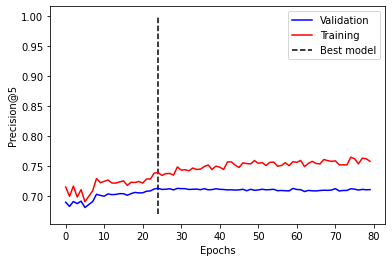

In [11]:
import matplotlib.pyplot as plt

plt.plot(val_p, color='b', label='Validation')
plt.plot(train_p, color='r', label='Training')
plt.vlines(np.argmax(val_p),0.67,1.0, linestyles='dashed', label='Best model')
plt.ylabel('Precision@5')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [12]:
## n_users=14811
## n_beers=52583
## device:gpu
## hidden_size=150
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
best_model = NeuMF(gmf_model=gmf_model, mlp_model=mlp_model, n_input=30, device=device)
#torch.save(best_state_dict, "/content/drive/MyDrive/CS247/Models/checkpoints/neu_mf.pth")
best_model.load_state_dict(best_state_dict['model_state_dict'])

<All keys matched successfully>

In [13]:
#label_pred = 'pred_y'
best_model.to(device)
best_model.eval()
test_data[label_pred] = (best_model.predict(test_data)>0.5).cpu().detach().numpy().astype(int)
test_data

,user_id,beer_id,review_overall,pred_y
0,0,5892,4.0,1
1,2,5892,4.0,1
2,9,5892,4.0,1
3,12,5892,4.0,0
4,17,5892,5.0,1
...,...,...,...,...
300822,14731,14334,2.5,1
300823,14776,42943,4.5,1
300824,14780,22042,4.5,1
300825,14785,36467,3.5,1


In [14]:
#threshold=4
#k=5
test_prec, test_recall = precision_recall_at_k(test_data, label_pred=label_pred, threshold=threshold, k=k)
# Precision and recall can then be averaged over all users
print("precision at 5 for test set: ", sum(prec for prec in test_prec.values()) / len(test_prec))
print("recall at 5 for test set:", sum(rec for rec in test_recall.values()) / len(test_prec))

precision at 5 for test set:  0.6802134702425344
recall at 5 for test set: 0.5491672346200788
